Fitting 5 folds for each of 10 candidates, totalling 50 fits
SVM Accuracy: 0.859375
Random Forest Accuracy: 0.8020833333333334
XGBoost Accuracy: 0.8229166666666666
Gradient Boosting Accuracy: 0.7760416666666666
Stacking Classifier Accuracy: 0.84375
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.86        96
           1       0.86      0.86      0.86        96

    accuracy                           0.86       192
   macro avg       0.86      0.86      0.86       192
weighted avg       0.86      0.86      0.86       192

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.81      0.80        96
           1       0.81      0.79      0.80        96

    accuracy                           0.80       192
   macro avg       0.80      0.80      0.80       192
weighted avg       0.80      0.80      0.80       192

XGBoost Classification Report:


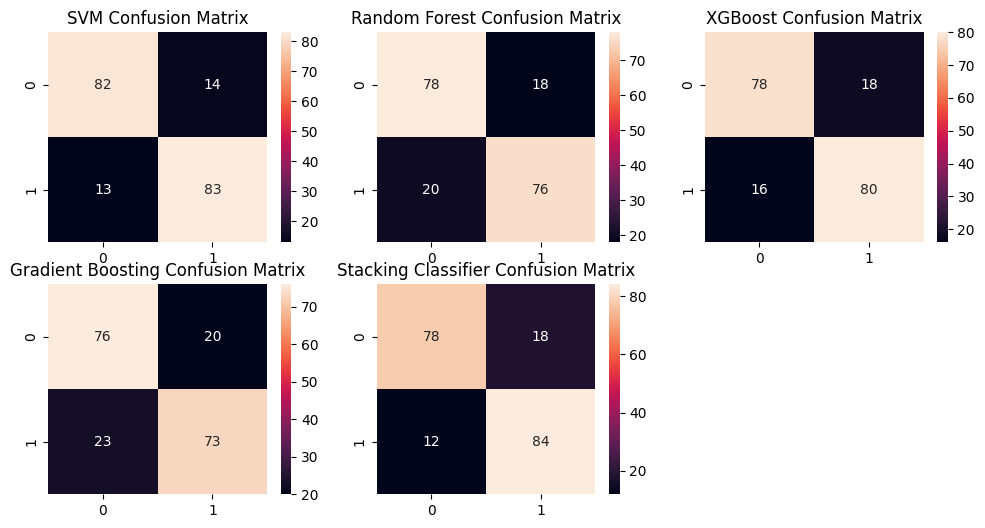

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('diabetes.csv')

# Handle missing values by replacing 0s with median for specific columns
columns_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in columns_to_replace:
    df[col].replace(0, df[col].median(), inplace=True)

# Feature Engineering: Add new features
df['BMI_Age_Ratio'] = df['BMI'] / (df['Age'] + 1)
df['Age_Squared'] = df['Age'] ** 2
df['BMI_Squared'] = df['BMI'] ** 2
df['Glucose_BMI_Interaction'] = df['Glucose'] * df['BMI']

df['Age_Log'] = np.log1p(df['Age'])
df['Insulin_Log'] = np.log1p(df['Insulin'])

# Polynomial Features for non-linear relationships
poly = PolynomialFeatures(degree=2, interaction_only=True)
X_poly = poly.fit_transform(df.drop('Outcome', axis=1))
y = df['Outcome']

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X_poly)

# Apply SMOTE + Tomek Links to balance classes
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# Feature Selection using XGBoost feature importance
xgb_feat_selector = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=500, learning_rate=0.05, max_depth=10)
xgb_feat_selector.fit(X_resampled, y_resampled)
important_features = np.argsort(xgb_feat_selector.feature_importances_)[-20:]
X_selected = X_resampled[:, important_features]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_resampled, test_size=0.20, stratify=y_resampled, random_state=42)

# Optimize SVM with RandomizedSearchCV for better hyperparameter tuning
param_dist = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly']
}

svm_model = SVC(probability=True)
random_search = RandomizedSearchCV(svm_model, param_dist, n_iter=10, cv=5, n_jobs=-1, verbose=1, random_state=42)
random_search.fit(X_train, y_train)
best_svm = random_search.best_estimator_

# Train RandomForestClassifier with optimized parameters
rf_model = RandomForestClassifier(n_estimators=700, max_depth=25, min_samples_split=4, min_samples_leaf=1, random_state=42)
rf_model.fit(X_train, y_train)

# Train XGBoost Classifier with tuned parameters
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=700, learning_rate=0.03, max_depth=12)
xgb_model.fit(X_train, y_train)

# Train Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=700, learning_rate=0.03, max_depth=12, random_state=42)
gb_model.fit(X_train, y_train)

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[('svm', best_svm), ('rf', rf_model), ('xgb', xgb_model), ('gb', gb_model)],
    final_estimator=SVC(probability=True)
)
stacking_clf.fit(X_train, y_train)

# Predictions
y_pred_svm = best_svm.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)
y_pred_stacking = stacking_clf.predict(X_test)

# Model Evaluation
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Stacking Classifier Accuracy:", accuracy_score(y_test, y_pred_stacking))

# Print Classification Reports
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Gradient Boosting Classification Report:\n", classification_report(y_test, y_pred_gb))
print("Stacking Classifier Classification Report:\n", classification_report(y_test, y_pred_stacking))

# Confusion Matrix
plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d')
plt.title("SVM Confusion Matrix")

plt.subplot(2, 3, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d')
plt.title("Random Forest Confusion Matrix")

plt.subplot(2, 3, 3)
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d')
plt.title("XGBoost Confusion Matrix")

plt.subplot(2, 3, 4)
sns.heatmap(confusion_matrix(y_test, y_pred_gb), annot=True, fmt='d')
plt.title("Gradient Boosting Confusion Matrix")

plt.subplot(2, 3, 5)
sns.heatmap(confusion_matrix(y_test, y_pred_stacking), annot=True, fmt='d')
plt.title("Stacking Classifier Confusion Matrix")

plt.show()
